### LSTM System Identification

Ananda Cahyo Wibowo/07111940000128
Undergrad Thesis Title : Data Driven Gas Lift Well And Network Optimization With Neural Network Based System Identification Using Modbus Simulator

Data Preparation

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

#Read the csv file
df = pd.read_csv("upsample_min.csv")
df = pd.read_csv("upsample.csv")
df2=df.drop(df.columns[0], axis=1)
data = df['GLIR'].to_numpy()

split = 0.75

x1 = df['GLIR'].to_numpy()[:int(split*len(data))]
x1 = x1.reshape(len(x1),1)
y1 = df['Qo'].to_numpy()[:int(split*len(data))]
y1 = y1.reshape(len(y1),1)

x2 = df['GLIR'].to_numpy()[int(split*len(data)):]
y2 = df['Qo'].to_numpy()[int(split*len(data)):]

print(f"ukuran x train: {np.shape(x1)} ukuran y train: {np.shape(y1)}")
print(f"ukuran x test: {np.shape(x2)} ukuran y test: {np.shape(y2)}")

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ukuran x train: (2772, 1) ukuran y train: (2772, 1)
ukuran x test: (924,) ukuran y test: (924,)


## Train Data

Preprocessing Data

In [2]:
#New dataframe with only training data
df_for_training_x = x1
df_for_training_y = y1

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training_x)
scaler2 = scaler.fit(df_for_training_y)
df_for_training_scaled_x = scaler.transform(df_for_training_x)
df_for_training_scaled_y = scaler2.transform(df_for_training_y)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled_x) - n_future +1):
    trainX.append(df_for_training_scaled_x[i - n_past:i, 0:df_for_training_x.shape[1]])

for i in range(n_past, len(df_for_training_scaled_y) - n_future +1):
    trainY.append(df_for_training_scaled_y[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (2758, 14, 1).
trainY shape == (2758, 1).


RNN LSTM Architecture & Training

In [3]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary("")


# fit the model
history = model.fit(trainX, trainY, epochs=15, batch_size=15, validation_split=0.1, verbose=1)

#model.save("RNN_model")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 62,369
Trainable params: 62,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
166/166 [==============================] 

Weights and Biasses

In [6]:
layers = [0,1,2,4] #layer 0:lstm 1:lstm 3:dense

weights = {}
biases = {}
for layer in layers:
    weights[layer] = model.layers[layer].get_weights()[0]
    biases[layer] = model.layers[layer].get_weights()[1]

nlayer = 1
print(np.shape(weights[nlayer]))
print(weights[nlayer])

print(np.shape(biases[nlayer]))
print(biases[nlayer])

(64, 256)
[[ 0.04383175  0.0206681   0.04615165 ...  0.09792855  0.07887287
   0.11442039]
 [ 0.0465111   0.0712297   0.08823249 ... -0.10304689 -0.08794636
   0.20533359]
 [ 0.1329307   0.01906153 -0.10221643 ...  0.03184018 -0.03268477
  -0.00345066]
 ...
 [ 0.03715495 -0.06231789 -0.06870147 ... -0.27581412 -0.19097927
  -0.09157588]
 [-0.00951145 -0.03851822  0.06636646 ... -0.06152402 -0.05934254
   0.11730397]
 [-0.12021871  0.0778846  -0.09994584 ... -0.12982817  0.06246351
   0.01023925]]
(64, 256)
[[ 0.03773573 -0.00332685  0.08136804 ... -0.07964008 -0.08983251
   0.09351236]
 [ 0.07578952 -0.13739236  0.00053007 ...  0.07803895 -0.03058156
  -0.18201643]
 [ 0.07471482  0.0056279   0.02827439 ...  0.07908455 -0.17991094
   0.08754878]
 ...
 [-0.0176761   0.05995606 -0.10373104 ... -0.04391942 -0.14110282
   0.07707703]
 [ 0.04913453  0.04599454 -0.13795654 ...  0.00441149 -0.00163624
   0.20372231]
 [ 0.10891373 -0.01849078 -0.05939338 ...  0.03203424 -0.02795685
   0.0205126

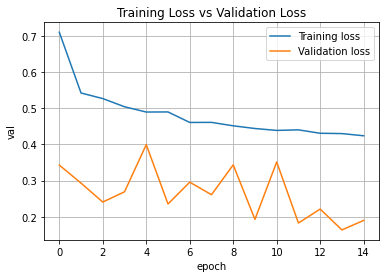

In [7]:
xx = np.arange(0,len(history.history['loss']))

"""print(history.history['loss'])
print(history.history['val_loss'])
print(xx)"""

plt.figure(1)
plt.plot(xx,history.history['loss'], label='Training loss')
plt.plot(xx,history.history['val_loss'], label='Validation loss')
plt.title("Training Loss vs Validation Loss")
plt.xlabel("epoch")
plt.ylabel("val")
plt.legend()
plt.grid()

Predicting Values

87/87 [==============================] - 1s 5ms/step
nilai pred: [[146.91348]
 [146.78952]
 [146.93802]
 ...
 [249.87494]
 [247.48045]
 [246.19815]]
ukuran y: (2758, 1) ukuran y pred: (2758, 1)


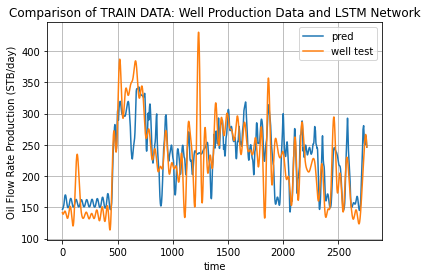

In [8]:
#Make prediction
#model = keras.models.load_model("RNN_Model")

n_days_for_prediction = 20
prediction = model.predict(trainX[:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range

prediction_copies = np.repeat(prediction, df_for_training_y.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)

print('nilai pred:',y_pred_future)

yy = scaler.inverse_transform(trainY)

x_axis = np.arange(0,y_pred_future.shape[0])

print(f"ukuran y: {np.shape(yy)} ukuran y pred: {np.shape(y_pred_future)}")

plt.figure(2)
plt.plot(x_axis,y_pred_future, label='pred')
plt.plot(x_axis,yy, label='well test')
plt.title("Comparison of TRAIN DATA: Well Production Data and LSTM Network")
plt.xlabel("time")
plt.ylabel("Oil Flow Rate Production (STB/day)")
plt.legend()
plt.grid()
plt.show()

Metric

In [9]:
import math
from sklearn.metrics import r2_score

MSE = np.square(np.subtract(yy,y_pred_future)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:")
print(RMSE)

r2 = r2_score(yy,y_pred_future)
print("\nR2 Value:")
print(r2)

Root Mean Square Error:
39.75015572724974

R2 Value:
0.6210719443105861


## Forecasting Value/Test Data

In [13]:
#df2 = pd.read_csv("upsample.csv")
#df2 = df2.iloc[:,0:152]
x2 = df['GLIR'].to_numpy()[int(split*len(data)):]
y2 = df['Qo'].to_numpy()[int(split*len(data)):]

#x2 = df2['GLIR'].to_numpy()
#y2 = df2['Qo'].to_numpy()

#New dataframe with only testing data
x2 = x2.reshape(len(x2),1)
y2 = y2.reshape(len(y2),1)
df_for_testing_x = x2
df_for_testing_y = y2

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_testing_x)
scaler2 = scaler.fit(df_for_testing_y)

df_for_testing_scaled_x = scaler.transform(df_for_testing_x)
df_for_testing_scaled_y = scaler2.transform(df_for_testing_y)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for testing). 

#Empty lists to be populated using formatted testing data
testX = []
testY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_testing_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_testing_scaled_x) - n_future +1):
    testX.append(df_for_testing_scaled_x[i - n_past:i, 0:df_for_testing_x.shape[1]])

for i in range(n_past, len(df_for_testing_scaled_y) - n_future +1):
    testY.append(df_for_testing_scaled_y[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (910, 14, 1).
testY shape == (910, 1).


29/29 [==============================] - 0s 5ms/step
ukuran y: (910, 1) ukuran y pred: (910, 1)


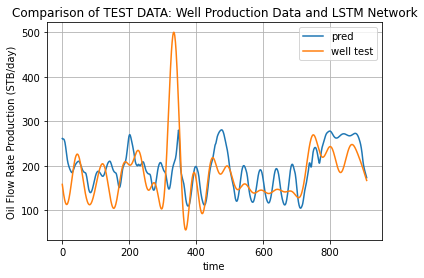

In [17]:
#Make forecast
#model = keras.models.load_model("RNN_Model")

n_days_for_forecast = 20
forecast = model.predict(testX[:]) #shape = (n, 1) where n is the n_days_for_forecast

#Perform inverse transformation to rescale back to original range

forecast_copies = np.repeat(forecast, df_for_testing_y.shape[1], axis=-1)
y_fore_future = scaler.inverse_transform(forecast_copies)

#print('nilai pred:',y_fore_future)

yyy = scaler.inverse_transform(testY)

x_axis = np.arange(0,y_fore_future.shape[0])

print(f"ukuran y: {np.shape(yyy)} ukuran y pred: {np.shape(y_fore_future)}")

plt.figure(2)
plt.plot(x_axis,y_fore_future, label='pred')
plt.plot(x_axis,yyy, label='well test')
plt.title("Comparison of TEST DATA: Well Production Data and LSTM Network")
plt.xlabel("time")
plt.ylabel("Oil Flow Rate Production (STB/day)")
plt.legend()
plt.grid()
plt.show()

Metric

In [18]:
import math
from sklearn.metrics import r2_score

MSE = np.square(np.subtract(yyy,y_fore_future)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:")
print(RMSE)

r2 = r2_score(yyy,y_fore_future)
print("\nR2 Value:")
print(r2)

Root Mean Square Error:
62.059355887948136

R2 Value:
0.09521765390526815
